In [1]:
import abc

In [2]:
import numpy as np

In [3]:
np.seterr(all='raise', under='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [4]:
np.set_printoptions(precision=20)

---

In [5]:
import simple_nn.layers.components.activation as actv
import simple_nn.gd_updater as gd_upd

In [6]:
from simple_nn.layers.nn_layer import FCLayer
from simple_nn.nn_model import *
from simple_nn.cost_function import *

---

batch norm

In [7]:
#TODO: BatchNorm

---

test - regression

In [8]:
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn import metrics

In [9]:
test_data = sklearn.datasets.load_boston(return_X_y=False)

In [10]:
test_data_x_org = test_data['data']
test_data_y_org = test_data['target']

In [11]:
test_data_x_org.shape

(506, 13)

In [12]:
test_data_std = (test_data_x_org - np.mean(test_data_x_org, axis=0)) / np.std(test_data_x_org, axis=0)

In [13]:
test_data_x = test_data_std[:450]
test_data_y = test_data_y_org[:450, None]

In [14]:
learning_rate = 0.01

In [15]:
m = NNModel(test_data_x.shape[1],
            gd_upd.GDUpdaterAdam(),
            cost_function=SquaredLoss())

In [16]:
# m.add_layer(FCLayer(20, False, ActivationNone()))
m.add_layer(FCLayer(node_count=10, activation=actv.ActivationLeakyRelu()))
m.add_layer(FCLayer(node_count=1, activation=actv.ActivationLeakyRelu()))

In [17]:
%%time
all_cost = m.fit(test_data_x, test_data_y, epoch=2000, batch_size=50, random_shuffle=True)

Wall time: 4.96 s


In [18]:
all_cost[-1]

3.3983670560497652

In [19]:
plt.figure(figsize=(15,6))
plt.plot(all_cost)

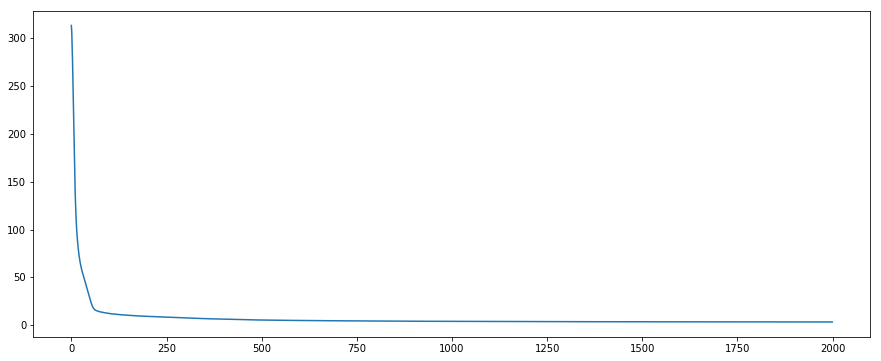

In [20]:
plt.show()

In [21]:
predict_data_x = test_data_std[450:]
predict_data_y = test_data_y_org[450:]

In [22]:
predict_y = []
for sample, tgt in zip(predict_data_x, predict_data_y):
    pct = m.transform(sample)
    predict_y.append(pct)

In [23]:
metrics.mean_squared_error(predict_data_y, predict_y)

13.885950563631981

test - logistic

In [24]:
test_iris = sklearn.datasets.load_iris(return_X_y=False)

In [25]:
test_data_x_org = test_iris['data']
test_data_y_org = test_iris['target']

In [26]:
test_data_x_org.shape

(150, 4)

In [27]:
test_data_std = (test_data_x_org - np.mean(test_data_x_org, axis=0)) / np.std(test_data_x_org, axis=0)

In [28]:
test_data_y_encoded = np.zeros((150,3))
test_data_y_encoded[np.arange(150),test_data_y_org] = 1

In [29]:
test_data_x = test_data_std
test_data_y = test_data_y_encoded

In [30]:
learning_rate = 0.001

In [31]:
m = NNModel(test_data_x.shape[1],
            gd_upd.GDUpdaterRMSprop(learning_rate=learning_rate),
            cost_function=CrossEntropy())

In [32]:
# m.add_layer(FCLayer(20, False, ActivationNone()))
m.add_layer(FCLayer(node_count=6, activation=actv.ActivationLeakyRelu()))
m.add_layer(FCLayer(node_count=3, activation=actv.ActivationSoftmax()))

In [33]:
%%time
all_cost = m.fit(test_data_x, test_data_y, epoch=10000, batch_size=15, random_shuffle=True)

Wall time: 33.6 s


In [34]:
all_cost[-1]

0.040848559087647944

In [35]:
plt.figure(figsize=(15,6))
plt.plot(all_cost)

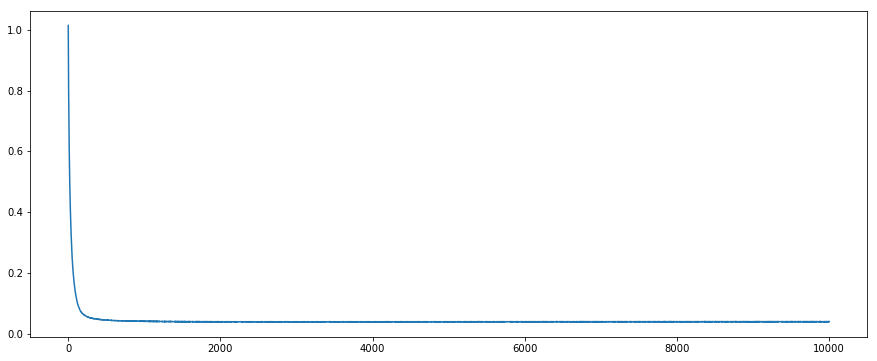

In [36]:
plt.show()

In [37]:
predict_data_x = test_data_std
predict_data_y = test_data_y_encoded

In [38]:
predict_y = []
predict_result = []
for sample, tgt in zip(predict_data_x, predict_data_y):
    pct = m.transform(sample)
    predict_result.append(pct)
    res = np.argmax(pct)
    predict_y.append(res)

In [39]:
predict_result

[array([  9.99999999352574109324e-01,   6.47425985449092183612e-10,
          3.15678411361658692570e-28]),
 array([  9.99999887523642216891e-01,   1.12476357879948573571e-07,
          2.36805992776489214617e-25]),
 array([  9.99999999892560831327e-01,   1.07439201520998833397e-10,
          2.88121337831043638230e-28]),
 array([  9.99999999629536118206e-01,   3.70463820414258087576e-10,
          4.36819513203918355339e-27]),
 array([  9.99999999973438802314e-01,   2.65611507659730969351e-11,
          1.83653009023082129177e-29]),
 array([  9.99999997270342388944e-01,   2.72965754232528252218e-09,
          1.87028303043079655489e-26]),
 array([  9.99999999996501465205e-01,   3.49852838612713091787e-12,
          8.80613678050260103406e-29]),
 array([  9.99999998733045236676e-01,   1.26695477682896222529e-09,
          1.72047292968305575315e-27]),
 array([  9.99999999740670553194e-01,   2.59329336509876871878e-10,
          6.02749716597217391866e-27]),
 array([  9.9999998374760701

In [40]:
metrics.confusion_matrix(predict_data_y.argmax(axis=1), predict_y)

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  1, 49]])

test - bio-logistic

In [41]:
test_breast = sklearn.datasets.load_breast_cancer(return_X_y=False)

In [42]:
test_data_x_org = test_breast['data']
test_data_y_org = test_breast['target']

In [43]:
test_data_x_org.shape

(569, 30)

In [44]:
test_data_std = (test_data_x_org - np.mean(test_data_x_org, axis=0)) / np.std(test_data_x_org, axis=0)

In [45]:
test_data_x = test_data_std[:450]
test_data_y = test_data_y_org[:450, None]

In [46]:
learning_rate = 0.001

In [47]:
m = NNModel(test_data_x.shape[1],
            gd_upd.GDUpdaterRMSprop(learning_rate=learning_rate),
            cost_function=SigmoidCrossEntropy())

In [48]:
m.add_layer(FCLayer(node_count=15, activation=actv.ActivationLeakyRelu()))
m.add_layer(FCLayer(node_count=1, activation=actv.ActivationSigmoid()))

In [49]:
%%time
all_cost = m.fit(test_data_x, test_data_y, epoch=5000, batch_size=50, random_shuffle=True)

Wall time: 17.7 s


In [50]:
all_cost[-1]

1.3347406589335269e-06

In [51]:
plt.figure(figsize=(15,6))
plt.plot(all_cost)

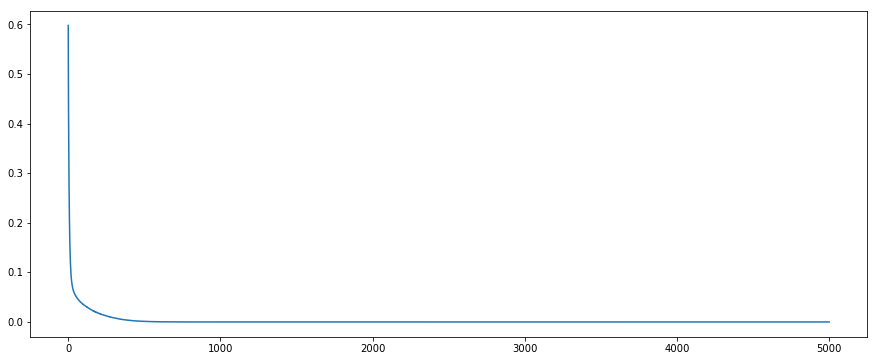

In [52]:
plt.show()

In [53]:
predict_data_x = test_data_std[450:]
predict_data_y = test_data_y_org[450:, None]

In [54]:
predict_y = m.transform(predict_data_x)

In [55]:
predict_y

array([[  1.00000000000000000000e+000],
       [  7.39097546161204853127e-047],
       [  9.99999999999985789145e-001],
       [  1.00000000000000000000e+000],
       [  1.00000000000000000000e+000],
       [  2.48941489851772388905e-003],
       [  9.99891656116070337568e-001],
       [  9.81415978627420027003e-001],
       [  9.99980114593369329157e-001],
       [  1.00000000000000000000e+000],
       [  1.09645032167760609398e-084],
       [  7.12457640674128451016e-218],
       [  9.99999931685144671789e-001],
       [  1.00000000000000000000e+000],
       [  9.99999999999999555911e-001],
       [  9.99999999999999111822e-001],
       [  9.99999999961983965235e-001],
       [  1.00000000000000000000e+000],
       [  1.05359774221665205075e-057],
       [  2.89598201268796793389e-003],
       [  1.00000000000000000000e+000],
       [  9.83101691417770262582e-001],
       [  9.99999999994072741316e-001],
       [  9.99999999999982902565e-001],
       [  1.00000000000000000000e+000],


In [56]:
metrics.accuracy_score(predict_data_y, [1 if pct > 0.5 else 0 for pct in predict_y])

0.94957983193277307

In [57]:
metrics.confusion_matrix(predict_data_y, [1 if pct > 0.5 else 0 for pct in predict_y])

array([[26,  1],
       [ 5, 87]])